# Final Project: Enhanced Pair Trading

##  Group Member:

**Kangyi Chen    12333907**

**Conghan Yao   12334724**

**Ziqi Wang    12334217**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import datetime
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.manifold import TSNE
import matplotlib.cm as cm
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from itertools import combinations

## 1. Load Data

In [2]:
rp = pd.read_csv("ravenpack_all.csv",encoding = 'unicode_escape')

In [3]:
entity_id = rp.RP_ENTITY_ID.unique()

In [4]:
with open('readme.txt', 'w') as f:
    f.write('\n'.join(entity_id))

Submit a query to Ravenpack database to get the mapping file

In [5]:
rp_map = pd.read_csv("ravenpack_map.csv",encoding = 'unicode_escape')

In [6]:
ticker = rp_map[rp_map['DATA_TYPE'] == "TICKER"].DATA_VALUE.unique()

In [7]:
with open('readme2.txt', 'w') as f:
    f.write('\n'.join(ticker))

Submit a query to CRSP database to get stock price

In [8]:
crsp = pd.read_csv("crsp.csv",encoding = 'unicode_escape')

## 2. Data Preprocessing

### (1) Get the price dataframe, with index = date, columns = ticker

In [9]:
price = crsp.copy()

In [10]:
price = price[['date','TICKER','PRC']]

In [11]:
price['date'] = pd.to_datetime(price['date'],format='%Y%m%d')

In [12]:
price = price[price['TICKER'].notna()]

In [13]:
price = price.pivot_table(index = 'date', columns = 'TICKER', values = 'PRC')

### (2) Add industry information to companies

In [14]:
SIC_CODE = pd.read_excel('SIC code meaning.xlsx')
SIC_CODE.head()

,SIC Code,Office,Industry Title
0,100,Office of Life Sciences,AGRICULTURAL PRODUCTION-CROPS
1,200,Office of Life Sciences,AGRICULTURAL PROD-LIVESTOCK & ANIMAL SPECIALTIES
2,700,Office of Life Sciences,AGRICULTURAL SERVICES
3,800,Office of Life Sciences,FORESTRY
4,900,Office of Life Sciences,"FISHING, HUNTING AND TRAPPING"


In [15]:
def string_filter(x):
    if str(x).isalpha():
        return False
    else:
        return True

In [16]:
returns = crsp[['date','TICKER','RET', 'SICCD']].copy()
returns = returns.merge(SIC_CODE, how = 'left', left_on='SICCD', right_on='SIC Code')
returns.drop(['Office', 'SICCD'], axis = 1, inplace = True)
returns.dropna(axis=0, inplace=True)
returns = returns[returns['RET'].apply(string_filter)]
returns['RET'] = returns['RET'].astype(float)
returns

,date,TICKER,RET,SIC Code,Industry Title
0,20000103,HON,-0.017335,3714.0,MOTOR VEHICLE PARTS & ACCESSORIES
1,20000104,HON,-0.017641,3714.0,MOTOR VEHICLE PARTS & ACCESSORIES
2,20000105,HON,-0.013468,3714.0,MOTOR VEHICLE PARTS & ACCESSORIES
3,20000106,HON,0.019340,3714.0,MOTOR VEHICLE PARTS & ACCESSORIES
4,20000107,HON,0.053571,3714.0,MOTOR VEHICLE PARTS & ACCESSORIES
...,...,...,...,...,...
2668088,20190612,BORN,-0.053693,6799.0,"INVESTORS, NEC"
2668089,20190613,BORN,-0.051396,6799.0,"INVESTORS, NEC"
2668090,20190614,BORN,-0.018925,6799.0,"INVESTORS, NEC"
2668091,20190617,BORN,-0.179355,6799.0,"INVESTORS, NEC"


### (3) Set ticker_list

In [17]:
ticker_list = returns.TICKER.unique()

In [18]:
ticker_list = rp_map[rp_map['DATA_VALUE'].isin(ticker_list)].DATA_VALUE.unique()

In [19]:
price = abs(price[ticker_list])

In [20]:
price

TICKER,BT,ALA,ALU,CGO,FUJI,FUJIY,NMR,CISG,FANH,AF,...,ING,CX,VE,ABEV,ABV,TRR,CTEL,HKTV,EDN,DQ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,47.375,6.6250,26.4375,NaN,37.5000,NaN,NaN,NaN,12.1875,...,61.3125,27.3750,NaN,NaN,NaN,7.8125,20.500,NaN,NaN,NaN
2000-01-04,NaN,44.250,6.5625,25.8750,NaN,34.1875,NaN,NaN,NaN,11.9375,...,59.6875,25.3125,NaN,NaN,NaN,7.7500,19.500,NaN,NaN,NaN
2000-01-05,NaN,44.250,6.5000,25.1875,NaN,35.5625,NaN,NaN,NaN,11.8125,...,60.1875,25.1250,NaN,NaN,NaN,7.7500,19.125,NaN,NaN,NaN
2000-01-06,NaN,41.750,6.3125,25.8750,NaN,37.7500,NaN,NaN,NaN,11.8750,...,59.7500,24.9375,NaN,NaN,NaN,7.8125,14.500,NaN,NaN,NaN
2000-01-07,NaN,44.000,6.5000,27.7500,NaN,39.4375,NaN,NaN,NaN,11.8125,...,60.8125,25.3750,NaN,NaN,NaN,7.7500,16.000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25,NaN,NaN,NaN,13.6300,NaN,NaN,4.52,NaN,6.88,NaN,...,14.5400,5.9600,NaN,2.79,NaN,NaN,NaN,NaN,4.7999,37.25
2022-01-26,NaN,NaN,NaN,13.6900,NaN,NaN,4.42,NaN,6.83,NaN,...,14.7400,5.9800,NaN,2.75,NaN,NaN,NaN,NaN,4.7200,37.82
2022-01-27,NaN,NaN,NaN,13.5000,NaN,NaN,4.41,NaN,6.48,NaN,...,14.6600,5.9500,NaN,2.83,NaN,NaN,NaN,NaN,4.6200,36.07


In [21]:
returns = returns[returns['TICKER'].isin(ticker_list)]

In [22]:
returns

,date,TICKER,RET,SIC Code,Industry Title
5557,20100803,BWC,-0.033693,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC"
5558,20100804,BWC,0.050961,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC"
5559,20100805,BWC,0.049766,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC"
5560,20100806,BWC,-0.023096,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC"
5561,20100809,BWC,-0.014517,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC"
...,...,...,...,...,...
2668088,20190612,BORN,-0.053693,6799.0,"INVESTORS, NEC"
2668089,20190613,BORN,-0.051396,6799.0,"INVESTORS, NEC"
2668090,20190614,BORN,-0.018925,6799.0,"INVESTORS, NEC"
2668091,20190617,BORN,-0.179355,6799.0,"INVESTORS, NEC"


### (4) Visualize companies in each industry

Text(0.5, 1.0, 'Return')

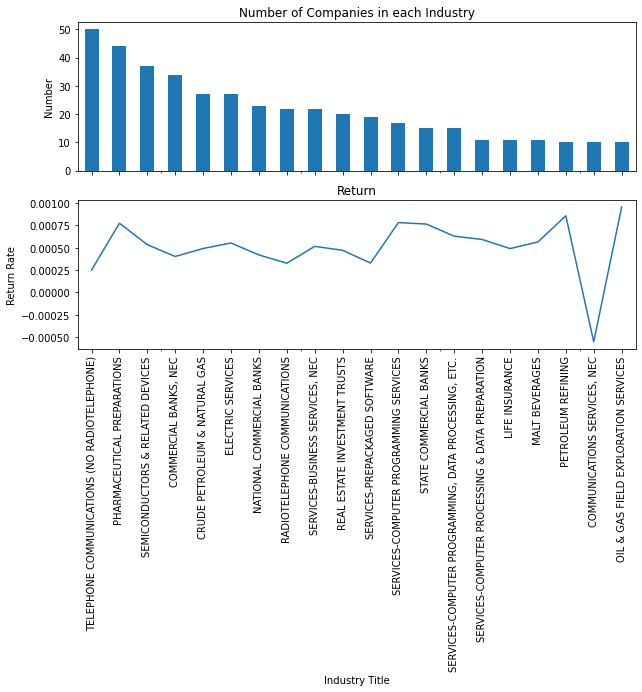

In [23]:
sector_info = returns.groupby('Industry Title').agg({'TICKER':'nunique', 'RET':'mean'}).sort_values('TICKER', ascending = False)
fig, ax = plt.subplots(2,1,sharex = True)
sector_info[sector_info['TICKER'] >= 10]['TICKER'].plot(kind = 'bar', figsize=(10,6), ax = ax[0])
ax[0].set_ylabel('Number')
ax[0].set_title('Number of Companies in each Industry')
sector_info[sector_info['TICKER'] >= 10]['RET'].plot(figsize=(10,6), ax = ax[1])
plt.xticks(rotation = 90)
ax[1].set_ylabel('Return Rate')
ax[1].set_title('Return')


### (5) Generate full_info table

In [24]:
use_rp_map = rp_map[rp_map['DATA_VALUE'].isin(ticker_list)]

In [25]:
use_rp_map = use_rp_map[use_rp_map['DATA_TYPE'] == "TICKER"]

In [26]:
use_rp_map = use_rp_map.groupby('DATA_VALUE').first()

In [27]:
use_rp_map.reset_index(inplace=True)

In [28]:
use_rp = rp.groupby('RP_ENTITY_ID').first()

In [29]:
full_data = pd.merge(use_rp_map,use_rp,left_on='RP_ENTITY_ID',right_on='RP_ENTITY_ID',how='left')

In [30]:
full_data

,DATA_VALUE,RP_ENTITY_ID,ENTITY_TYPE_x,DATA_TYPE,RANGE_START,RANGE_END,TIMESTAMP_UTC,RPNA_DATE_UTC,RPNA_TIME_UTC,ENTITY_TYPE_y,...,CSS,NIP,PEQ,BEE,BMQ,BAM,BCA,BER,ANL_CHG,MCQ
0,AAC,67A658,COMP,TICKER,2000-01-01,20070702.0,2000-01-11 14:17:24.000,20000111,14:17:24.000,COMP,...,50,41,50,50,50,50,50,50,50,50
1,AACG,E55727,COMP,TICKER,2019-10-17,NaN,2006-02-07 08:39:09.743,20060207,08:39:09.743,COMP,...,55,38,100,50,50,50,50,50,50,50
2,AAL,67A658,COMP,TICKER,2007-07-02,NaN,2000-01-11 14:17:24.000,20000111,14:17:24.000,COMP,...,50,41,50,50,50,50,50,50,50,50
3,AAUK,67A658,COMP,TICKER,2000-01-01,20070725.0,2000-01-11 14:17:24.000,20000111,14:17:24.000,COMP,...,50,41,50,50,50,50,50,50,50,50
4,ABB,5FC63E,COMP,TICKER,2000-01-01,NaN,2000-01-12 13:02:55.000,20000112,13:02:55.000,COMP,...,50,39,50,50,50,50,50,50,50,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,YOKU,2914B1,COMP,TICKER,2010-12-08,20160405.0,2008-03-17 06:00:00.000,20080317,06:00:00.000,COMP,...,50,54,50,50,50,50,50,50,50,50
600,YZC,58D16C,COMP,TICKER,2000-01-01,20170217.0,2000-04-17 10:52:00.000,20000417,10:52:00.000,COMP,...,46,69,50,50,0,0,50,100,50,0
601,ZNH,B23D1B,COMP,TICKER,2005-07-01,NaN,2000-01-04 05:00:00.000,20000104,05:00:00.000,COMP,...,50,26,50,50,50,50,50,50,50,50
602,ZTO,3940BA,COMP,TICKER,2016-10-24,NaN,2016-01-15 10:11:42.873,20160115,10:11:42.873,COMP,...,50,42,50,50,50,50,50,50,50,50


In [31]:
use_ticker = full_data[['DATA_VALUE', 'COUNTRY_CODE']].groupby('DATA_VALUE', as_index=False).last()
country_info = returns.merge(use_ticker, left_on='TICKER', right_on='DATA_VALUE', how = 'inner')\
    .groupby(['COUNTRY_CODE'])\
    .agg({'DATA_VALUE': 'nunique','RET':'mean'})\
    .sort_values('DATA_VALUE', ascending = False)
country_info.rename(columns={'DATA_VALUE':'TICKER'}, inplace = True)
country_info

,TICKER,RET
COUNTRY_CODE,,
GB,95,0.000369
CN,60,0.000583
FR,43,0.000509
AU,38,0.000743
DE,33,0.000375
KY,32,0.000707
JP,30,0.000253
BR,25,0.000626
NL,24,0.000475


In [32]:
full_info = returns.merge(use_ticker, left_on='TICKER', right_on='DATA_VALUE', how = 'inner')
full_info

,date,TICKER,RET,SIC Code,Industry Title,DATA_VALUE,COUNTRY_CODE
0,20100803,BWC,-0.033693,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
1,20100804,BWC,0.050961,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
2,20100805,BWC,0.049766,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
3,20100806,BWC,-0.023096,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
4,20100809,BWC,-0.014517,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
...,...,...,...,...,...,...,...
1528408,20190612,BORN,-0.053693,6799.0,"INVESTORS, NEC",BORN,KY
1528409,20190613,BORN,-0.051396,6799.0,"INVESTORS, NEC",BORN,KY
1528410,20190614,BORN,-0.018925,6799.0,"INVESTORS, NEC",BORN,KY
1528411,20190617,BORN,-0.179355,6799.0,"INVESTORS, NEC",BORN,KY


### (6) Visualize companies in each country

Text(0.5, 1.0, 'Return')

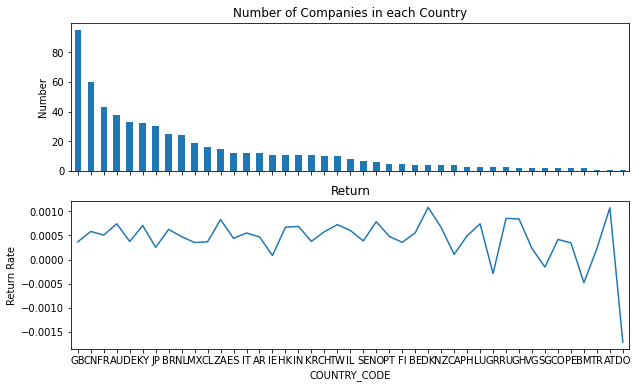

In [33]:
fig, ax = plt.subplots(2,1,sharex = True)
country_info['TICKER'].plot(kind = 'bar', figsize=(10,6), ax = ax[0])
ax[0].set_ylabel('Number')
ax[0].set_title('Number of Companies in each Country')
country_info['RET'].plot(figsize=(10,6), ax = ax[1])
ax[1].set_ylabel('Return Rate')
ax[1].set_title('Return')

### (7) Visualize 2 news indicators

In [34]:
news_score = rp[rp['RP_ENTITY_ID'].isin(list(full_data['RP_ENTITY_ID']))][['TIMESTAMP_UTC', 'RP_ENTITY_ID', 'COUNTRY_CODE', 'ESS', 'ENS', 'RELEVANCE']].copy()
news_score['TIMESTAMP_UTC'] = pd.to_datetime(news_score['TIMESTAMP_UTC']).dt.date
news_score = news_score[(news_score['ESS'] != 50) & (news_score['ENS'] == 100) & (news_score['RELEVANCE'] == 100)]
news_score['sent'] = (news_score['ESS']-50)/50
news_score = news_score.groupby(['TIMESTAMP_UTC', 'RP_ENTITY_ID']).agg({'RP_ENTITY_ID':'count', 'sent':'sum'})

In [35]:
AS_1D = (news_score['sent']/news_score['RP_ENTITY_ID']).to_frame('sentiment score')
AS_1D.reset_index(inplace = True)
AS_1D

,TIMESTAMP_UTC,RP_ENTITY_ID,sentiment score
0,2000-01-03,18200A,-0.12
1,2000-01-03,27F2F5,0.24
2,2000-01-03,417431,0.52
3,2000-01-03,44D13D,-0.20
4,2000-01-03,516A72,0.26
...,...,...,...
237038,2020-02-28,DB5E90,-0.37
237039,2020-02-28,E0427E,0.62
237040,2020-02-28,E4DCB7,-0.26
237041,2020-02-28,F92DBC,0.23


Text(0, 0.5, 'Average Daily Sentiment Indicator')

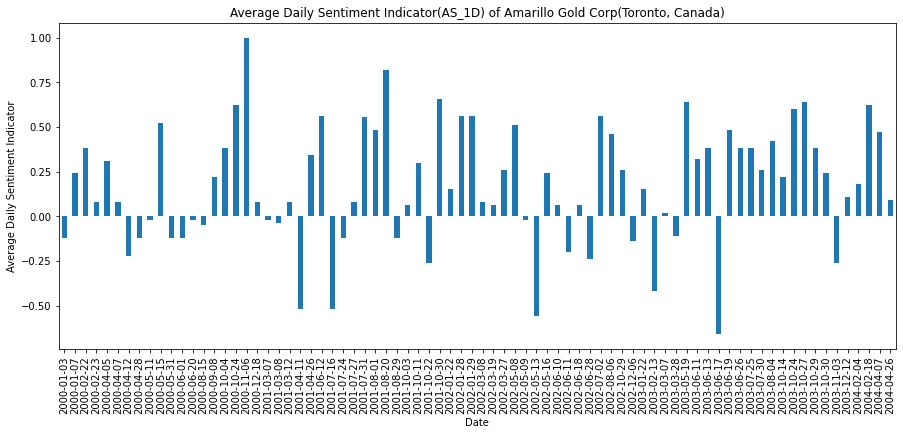

In [36]:
AS_1D[AS_1D['RP_ENTITY_ID'] == '18200A'].set_index('TIMESTAMP_UTC')\
    .plot(kind = 'bar', figsize = (15,6), legend = None)
plt.title('Average Daily Sentiment Indicator(AS_1D) of Amarillo Gold Corp(Toronto, Canada)')
plt.xlabel('Date')
plt.ylabel('Average Daily Sentiment Indicator')

In [37]:
ANV_1D = news_score.rename(columns={'RP_ENTITY_ID':'amount'}).reset_index()
ANV_1D = ANV_1D.pivot_table(index = 'TIMESTAMP_UTC', columns='RP_ENTITY_ID', values='amount', fill_value=0)
ANV_1Y_avg = ANV_1D.rolling(365).mean()
ANV_1Y_std = ANV_1D.rolling(365).std()
ANV_1D = ((ANV_1D-ANV_1Y_avg)/ANV_1Y_std)

Text(0, 0.5, 'Abnormal news volume')

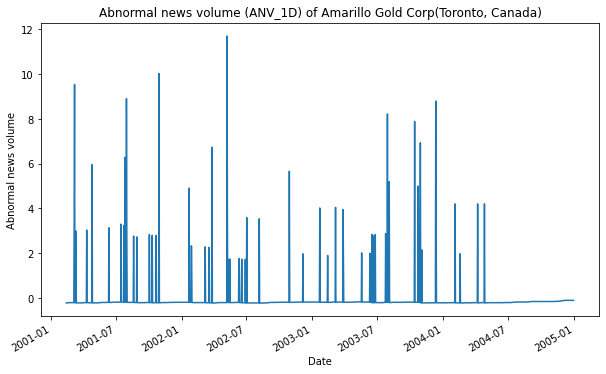

In [38]:
ANV_1D.index = pd.to_datetime(ANV_1D.index)
ANV_1D['18200A'][:'2004'].plot(figsize = (10,6), legend = None)
plt.title('Abnormal news volume (ANV_1D) of Amarillo Gold Corp(Toronto, Canada)')
plt.xlabel('Date')
plt.ylabel('Abnormal news volume')

## 3. Filter

### (1) Cluster

In [39]:
def apply_PCA(n_components, df, svd_solver='auto', random_state=0):

    pca = PCA(n_components=n_components, svd_solver=svd_solver, random_state=random_state)
    pca.fit(df)
    explained_variance = pca.explained_variance_

    # standardize
    X = preprocessing.StandardScaler().fit_transform(pca.components_.T)

    return X, explained_variance

In [40]:
# DBSCAN clustering algo
# eps: min distance for a sample to be within the cluster
# min_samples: min_samples to consider a cluster
# clustered_series_all: series with all tickers and labels
# clustered_series: series with tickers belonging to a cluster

def apply_DBSCAN(eps, min_samples, X, df_returns):

    clf = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')

    clf.fit(X)
    labels = clf.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Clusters discovered using DBSCAN: %d" % n_clusters_)

    clustered_series_all = pd.Series(index=df_returns.columns, data=labels.flatten())
    clustered_series = clustered_series_all[clustered_series_all != -1]

    counts = clustered_series.value_counts()
    print("Pairs to evaluate using DBSCAN: %d" % (counts * (counts - 1) / 2).sum())

    return clustered_series_all, clustered_series, counts, clf

In [41]:
def apply_OPTICS(X, df_returns, min_samples, max_eps=2, xi=0.05, cluster_method='xi'):

    clf = OPTICS(min_samples=min_samples, max_eps=max_eps, xi=xi, metric='euclidean', cluster_method=cluster_method)

    clf.fit(X)
    labels = clf.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Clusters discovered using OPTICS: %d" % n_clusters_)

    clustered_series_all = pd.Series(index=df_returns.columns, data=labels.flatten())
    clustered_series = clustered_series_all[clustered_series_all != -1]

    counts = clustered_series.value_counts()
    print("Pairs to evaluate using OPTICS: %d" % (counts * (counts - 1) / 2).sum())

    return clustered_series_all, clustered_series, counts, clf

In [42]:
# apply on "GB"
df = full_info[["date","TICKER","RET"]][full_info.COUNTRY_CODE == "GB"]
df = pd.pivot_table(df,index=["date"],columns=["TICKER"],fill_value=0)
df.columns = [el[1] for el in df.columns]

N_PRIN_COMPONENTS = 5
X, explained_variance = apply_PCA(N_PRIN_COMPONENTS, df, random_state=0)
print("Explained variance is ", explained_variance)

# clustered_series_all, clustered_series, counts, clf = apply_DBSCAN(0.10,3,X,df)

clustered_series_all, clustered_series, counts, clf = apply_OPTICS(X, df, min_samples=3, cluster_method='xi')



Explained variance is  [0.00573036 0.00352263 0.00259951 0.00196607 0.00171046]
Clusters discovered using OPTICS: 10
Pairs to evaluate using OPTICS: 91


In [43]:
def plot_TSNE(X, clf, clustered_series_all):
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=500).fit_transform(X)
    
    # visualization
    fig = plt.figure(1, facecolor='white', figsize=(15,15), frameon=True, edgecolor='black')
    plt.clf()
    
    ax = fig.add_subplot(1, 1, 1, alpha=0.9)
    
    ax.spines['left'].set_position('center')
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_position('center')
    ax.spines['bottom'].set_alpha(0.3)
    
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(which='major', labelsize=18)

  
    labels = clf.labels_
    x = X_tsne[(labels!=-1), 0]
    y = X_tsne[(labels!=-1), 1]
    tickers = list(clustered_series_all[clustered_series_all != -1].index)
    plt.scatter(
        x,
        y,
        s=300,
        alpha=0.75,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )
    for i, ticker in enumerate(tickers):
        plt.annotate(ticker, (x[i]-15, y[i]+15), size=10)


    x = X_tsne[(clustered_series_all==-1).values, 0]
    y = X_tsne[(clustered_series_all==-1).values, 1]
    tickers = list(clustered_series_all[clustered_series_all == -1].index)

    plt.scatter(
        x,
        y,
        s=50,
        alpha=0.20,
        c='black'
    )
   
    plt.xlabel('t-SNE Dim_1', position=(0.92,0), size=10)
    plt.ylabel('t-SNE Dim_2', position=(0,0.92), size=10)
    ax.set_xticks(range(-500, 501, 1000))
    ax.set_yticks(range(-500, 501, 1000))
    plt.show()


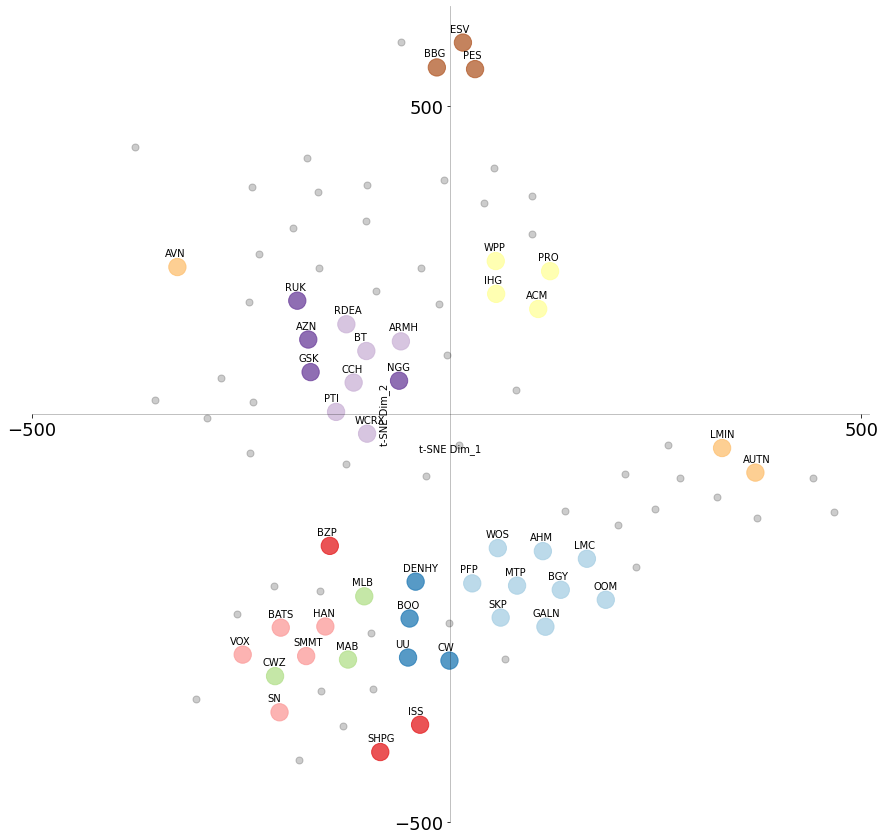

In [44]:
plot_TSNE(X,clf, clustered_series_all)

### (2) Factor correlation

In [101]:
## Fundamental risk model = country factor + industry factor + FF 5 factor model
ff = pd.read_csv("FF5factor.csv")

In [102]:
ff.set_index("date",inplace=True)

In [103]:
ff.drop(columns='RF',inplace=True)

In [104]:
for country in full_info.COUNTRY_CODE.unique():
    df = full_info[full_info.COUNTRY_CODE == country]
    df = df.groupby('date').mean()['RET']
    ff = ff.merge(df,how='left',left_index=True,right_index=True)
    ff = ff.rename(columns = {'RET':str(country)})

In [105]:
for industry in full_info['SIC Code'].unique():
    df = full_info[full_info['SIC Code'] == industry]
    df = df.groupby('date').mean()['RET']
    ff = ff.merge(df,how='left',left_index=True,right_index=True)
    ff = ff.rename(columns = {'RET':str(industry)})

In [106]:
ff = ff.fillna(0)

In [107]:
full_info

,date,TICKER,RET,SIC Code,Industry Title,DATA_VALUE,COUNTRY_CODE
0,20100803,BWC,-0.033693,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
1,20100804,BWC,0.050961,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
2,20100805,BWC,0.049766,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
3,20100806,BWC,-0.023096,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
4,20100809,BWC,-0.014517,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
...,...,...,...,...,...,...,...
1528408,20190612,BORN,-0.053693,6799.0,"INVESTORS, NEC",BORN,KY
1528409,20190613,BORN,-0.051396,6799.0,"INVESTORS, NEC",BORN,KY
1528410,20190614,BORN,-0.018925,6799.0,"INVESTORS, NEC",BORN,KY
1528411,20190617,BORN,-0.179355,6799.0,"INVESTORS, NEC",BORN,KY


In [108]:
df = full_info.pivot_table(index='date',columns='TICKER',values='RET')

In [109]:
df = df.fillna(0)

In [110]:
ff = ff.loc["200001":]

In [111]:
factor = pd.DataFrame(index=ff.columns)

In [118]:
# 跑得了循环就跑，跑不了就直接读文件
good_computer = False
if good_computer: 
    for i in df.columns:
        Y = df[i]
        X = sm.add_constant(ff)
        model = sm.OLS(Y,X).fit()
        factor[i] = model.params[1:]
else:
    cor = pd.read_csv('cor.csv')
    cor.set_index('Unnamed: 0', inplace = True)

In [ ]:
factor

In [77]:
factor_covariance = ff.cov()
factor_covariance

,Mkt-RF,SMB,HML,RMW,CMA,DE,VG,FR,NL,ES,...,7361.0,3944.0,4231.0,3713.0,2000.0,1531.0,3678.0,1520.0,8200.0,8011.0
Mkt-RF,1.566303,0.117223,0.082758,-0.242095,-0.130945,0.014454,0.004227,0.014147,0.016420,0.019063,...,0.007789,6.489001e-04,3.996315e-04,3.347866e-04,3.812376e-04,9.488417e-03,0.003042,7.411920e-03,0.004686,3.043077e-03
SMB,0.117223,0.407009,0.079177,-0.090906,0.018988,0.002697,0.001066,0.002303,0.002292,0.002471,...,0.002385,1.998744e-04,1.769472e-04,2.035763e-04,7.386328e-05,1.447009e-04,0.001007,9.774027e-04,0.002383,9.286090e-04
HML,0.082758,0.079177,0.589765,0.057348,0.150769,0.001398,0.000646,0.001331,0.004174,0.004191,...,0.000449,1.033369e-04,4.179654e-05,-1.260529e-05,-4.195791e-06,2.733214e-03,0.001014,2.946249e-03,0.001351,-8.000332e-05
RMW,-0.242095,-0.090906,0.057348,0.287284,0.064679,-0.003033,-0.000816,-0.002667,-0.002012,-0.002653,...,-0.000989,-2.701462e-04,-1.310526e-04,-4.711607e-05,-7.221073e-06,-7.672703e-04,-0.000556,-1.022591e-03,-0.001128,-4.787555e-04
CMA,-0.130945,0.018988,0.150769,0.064679,0.179995,-0.001069,-0.000011,-0.000774,-0.000335,-0.000671,...,-0.000518,1.905745e-04,1.268712e-04,1.519038e-05,-1.843726e-05,-6.753728e-04,0.000151,-3.939994e-04,-0.000532,9.928420e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531.0,0.009488,0.000145,0.002733,-0.000767,-0.000675,0.000092,0.000035,0.000094,0.000126,0.000143,...,0.000003,-8.314684e-09,2.392462e-08,-3.373406e-08,8.814299e-06,3.757945e-04,0.000023,1.569076e-04,0.000032,-7.093185e-08
3678.0,0.003042,0.001007,0.001014,-0.000556,0.000151,0.000034,0.000029,0.000037,0.000043,0.000047,...,0.000035,-8.381592e-09,2.411714e-08,-3.400552e-08,-1.997179e-08,2.326982e-05,0.000074,3.288589e-05,0.000007,4.996203e-06
1520.0,0.007412,0.000977,0.002946,-0.001023,-0.000394,0.000070,0.000026,0.000071,0.000105,0.000106,...,0.000024,5.802616e-09,-1.669641e-08,2.354218e-08,1.382656e-08,1.569076e-04,0.000033,4.473539e-04,0.000029,4.412930e-07
8200.0,0.004686,0.002383,0.001351,-0.001128,-0.000532,0.000027,0.000025,0.000050,0.000042,0.000141,...,0.000037,-7.726054e-08,2.223090e-07,-3.134589e-07,-1.840976e-07,3.182371e-05,0.000007,2.889896e-05,0.018347,2.728913e-04


In [ ]:
C = factor.transpose().dot(factor_covariance).dot(factor)

In [61]:
cor = C / (np.sqrt(np.diag(C))*np.sqrt(np.diag(C.transpose())))

In [119]:
cor

,AAC,AACG,AAL,AAUK,ABB,ABEV,ABG,ABI,ABN,ABV,...,XFML,XIN,XSEL,XTLB,YGE,YOKU,YZC,ZNH,ZTO,ZX
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AAC,1.000000,-0.000215,0.136356,0.021804,0.150383,-0.038064,-0.399217,0.053488,0.004215,0.232353,...,0.313691,0.099792,0.044612,-0.016397,0.132042,0.046922,0.049148,0.092838,-0.002251,-0.014182
AACG,-0.016904,1.000000,0.089515,-0.003295,-0.135709,-0.193802,1.074456,0.001218,-0.024422,-0.005280,...,-0.145198,0.149343,0.045004,0.038647,0.039842,0.065203,0.001100,-0.009095,-0.668414,0.161898
AAL,0.114413,0.000954,1.000000,-0.000267,0.146741,0.653919,0.938121,0.000214,-0.025064,0.023012,...,0.004956,0.090075,0.039894,0.006945,0.051896,0.085858,0.008656,0.201683,0.143874,0.040177
AAUK,0.019556,-0.000038,-0.000286,1.000000,0.170049,0.000115,1.479251,0.170172,0.646623,0.121137,...,0.032673,0.000235,0.000791,0.005015,0.003946,-0.000633,0.017715,0.064222,-0.000615,-0.000323
ABB,0.320688,-0.003677,0.372940,0.404312,1.000000,0.494747,1.703653,0.224208,0.690959,0.602109,...,0.490414,0.223937,0.222833,0.051044,0.336752,0.403366,0.092409,0.284167,0.196896,0.191878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YOKU,0.026294,0.000464,0.057341,-0.000395,0.105998,0.097740,2.169119,-0.001248,-0.000985,0.112263,...,0.033012,-0.000694,0.003288,-0.010244,0.146027,1.000000,0.049301,0.093129,-0.000298,0.308958
YZC,0.596210,0.000170,0.125146,0.239605,0.525677,0.233777,2.551031,0.155102,0.367583,0.721219,...,0.803012,0.295303,1.125801,0.045049,0.510083,1.067231,1.000000,0.558482,-0.002120,0.514082
ZNH,0.383356,-0.000477,0.992535,0.295676,0.550255,0.518967,1.482972,0.246463,0.398939,0.567755,...,0.481638,0.232098,0.312122,0.041889,0.360131,0.686242,0.190106,1.000000,0.283318,0.470421


### (3) Co-integration

In [63]:
def ticker_combinations(full_info, pivoted_return, ticker_1, ticker_2, critical = 0.9):
    """
    find pairs that pass the co-integration test at 90%* significance level.
    
    Parameters
    ---------------
    full_info: dataframe with country and industry information for each equity
    pivoted_return: return dataframe with date as index and ticker as column
    """
    pair_return = pivoted_return[[ticker_1,ticker_2]].dropna(axis = 0)
    model = coint_johansen(pair_return,0,1)
   
    
    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
        
    if critical == 0.9:
        x = 0
    elif critical == 0.95:
        x = 1
    else:
        x = 2
    
    trace_crit_value = model.cvt[:, x]
    eigen_crit_value = model.cvm[:, x]

    if np.all(model.lr1 >= trace_crit_value) and np.all(model.lr2 >= eigen_crit_value):
        return True
    
    return False

### (4) Half life

In [64]:
def halflife(price, sec_1, sec_2):
    spread = (price[sec_1] - price[sec_2]).to_numpy()
    s_lag = np.roll(spread,1)
    s_lag[0] = 0
    s_ret = spread - s_lag
    s_ret[0] = 0 
    s_lag2 = sm.add_constant(s_lag)
    model = sm.OLS(s_ret, s_lag2, missing='drop').fit()
    answer = -np.log(2) / model.params[1]
    return answer

## 4. Original model

In [ ]:
## training period = 12 months, trading period is 3 months, using GB stock as an example
ticker_list = full_info["TICKER"][full_info.COUNTRY_CODE == "GB"].unique()

In [ ]:
ticker_list

array(['WPPGY', 'WPP', 'SHP', 'ISS', 'SXC', 'VER', 'SN', 'LXFR', 'CCH',
       'AAUK', 'SC', 'BNL', 'ESV', 'RTP', 'AAC', 'AAL', 'VAL', 'MTP',
       'UL', 'SKY', 'MAB', 'REX', 'PES', 'BT', 'IMB', 'BCS', 'SHEL',
       'HAN', 'VOX', 'GSK', 'MNI', 'VOD', 'BAS', 'AVN', 'MRNT', 'DANKY',
       'AMRN', 'AZN', 'FMDA', 'ACS', 'RUK', 'RELX', 'BSY', 'CWC', 'PFP',
       'BATS', 'SMMT', 'EIDSY', 'SKP', 'BZP', 'CWZ', 'GLH', 'DENHY',
       'ARM', 'AHM', 'UU', 'SHPGY', 'SHPG', 'ARMHY', 'ARMH', 'SKYE',
       'NITE', 'NGG', 'SNN', 'BGY', 'RDEA', 'LMIN', 'AUTN', 'BOO', 'PUK',
       'TLNT', 'AV', 'PSO', 'GALN', 'WCRX', 'MONI', 'WOS', 'SPM', 'LMC',
       'CW', 'LYG', 'OOM', 'PRU', 'MRN', 'PML', 'IHG', 'MLB', 'BBL',
       'BBG', 'PTE', 'PTI', 'ACM', 'PRO', 'REED', 'CCM'], dtype=object)

In [ ]:
ticker_pair = list(combinations(ticker_list,2))

In [ ]:
price['date'] = price.index

In [ ]:
date_list = price.groupby([price.index.year,price.index.month]).first()['date']

### (1) Co-integrated pairs

In [ ]:
co_integrated_pair = []
for pair in ticker_pair:
    try:
        if ticker_combinations(full_info,price,pair[0],pair[1]) == True:
            co_integrated_pair.append(pair)
    except:
        continue

In [ ]:
len(ticker_pair)

4465

In [ ]:
len(co_integrated_pair)

661

### (2) pairs eligible for trading

In [ ]:
trading_pair = []
for pair in co_integrated_pair:
    if halflife(price,pair[0],pair[1]) < 30 and halflife(price,pair[0],pair[1])>0:
        trading_pair.append(pair)

In [ ]:
len(trading_pair)

101

### (3) pairs trading

In [ ]:
len(date_list)

265

In [ ]:
order = pd.DataFrame(0.0, index = price.index, columns = price.columns)

In [ ]:
for start_date_num in range(len(date_list)-15):
    train_start_date = date_list[start_date_num]
    train_end_date = date_list[start_date_num + 12]
    trade_end_date = date_list[start_date_num + 15]
    for pair in trading_pair:
        train_data = price.loc[train_start_date:train_end_date][[pair[0],pair[1]]]
        if train_data.isnull().values.any():
            continue
        # print(pair,train_start_date,trade_end_date)
        stock_high = pair[0]
        stock_low = pair[1]
        mean = np.mean(train_data[stock_high]) - np.mean(train_data[stock_low])
        ## determine which is high and which is low
        if mean < 0:
            stock_high, stock_low = stock_low, stock_high
            mean = -mean
        stdev = np.std(train_data[stock_high] - train_data[stock_low])
        half_life = round(halflife(price,stock_high,stock_low))
        trade_data = price.loc[train_end_date:trade_end_date][[stock_high,stock_low,'date']]
        position_open = False
        position_last = 0
        high_position = 0
        low_position = 0
        for i in range(len(trade_data)):
            current_column = trade_data.iloc[0]
            spread = current_column[stock_high] - current_column[stock_low]
            current_date = current_column.date
            ## if a stock is delisted, close position and break
            if trade_data.iloc[i].isnull().values.any():
                if position_open == True:
                    position_open = False
                    order.loc[current_date][stock_high] += -high_position
                    order.loc[current_date][stock_low] += -low_position
                    high_position = 0
                    low_position = 0
                    position_last = 0
                break
            ## if the spread has reverted / three half_life passed / end of 3-month, close position
            elif (spread < abs(mean)) or (position_last >= 3*half_life) or (i == len(trade_data)-1):
                if position_open == True:
                    position_open = False
                    order.loc[current_date][stock_high] += -high_position
                    order.loc[current_date][stock_low] += -low_position
                    high_position = 0
                    low_position = 0
                    position_last = 0
            ## if spread > 2stdev and remaining time greater than 2 half_life, open position
            elif (position_open == False) and (abs(spread-mean) > 2*stdev) and (len(trade_data)-i>2*half_life):
                position_open = True
                if spread-mean > 2*stdev:
                    high_position = -1
                    low_position = 1
                else:
                    high_position = 1
                    low_position = -1
                order.loc[current_date][stock_high] += high_position
                order.loc[current_date][stock_low] += low_position
                position_last = 1
            else:
                if position_open == True:
                    position_last += 1
                    
        

In [ ]:
order = order.drop(columns='date')

In [ ]:
price = price.drop(columns='date')

In [ ]:
capital0 = 100
holdings = (order*price).sum(axis=1)
cash = capital0 - (order.diff()*price).sum(axis=1).cumsum()
returns = ((cash+holdings).pct_change()+1).cumprod()-1
final = returns[-1]

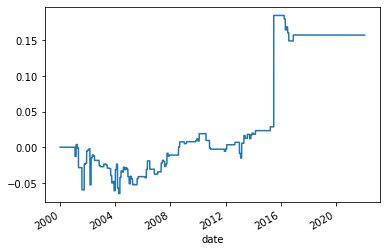

In [ ]:
returns.plot()

## 5. Enhanced model

In [65]:
ticker_list = full_info["TICKER"][full_info.COUNTRY_CODE == "GB"].unique()

In [66]:
ticker_list

array(['WPPGY', 'WPP', 'SHP', 'ISS', 'SXC', 'VER', 'SN', 'LXFR', 'CCH',
       'AAUK', 'SC', 'BNL', 'ESV', 'RTP', 'AAC', 'AAL', 'VAL', 'MTP',
       'UL', 'SKY', 'MAB', 'REX', 'PES', 'BT', 'IMB', 'BCS', 'SHEL',
       'HAN', 'VOX', 'GSK', 'MNI', 'VOD', 'BAS', 'AVN', 'MRNT', 'DANKY',
       'AMRN', 'AZN', 'FMDA', 'ACS', 'RUK', 'RELX', 'BSY', 'CWC', 'PFP',
       'BATS', 'SMMT', 'EIDSY', 'SKP', 'BZP', 'CWZ', 'GLH', 'DENHY',
       'ARM', 'AHM', 'UU', 'SHPGY', 'SHPG', 'ARMHY', 'ARMH', 'SKYE',
       'NITE', 'NGG', 'SNN', 'BGY', 'RDEA', 'LMIN', 'AUTN', 'BOO', 'PUK',
       'TLNT', 'AV', 'PSO', 'GALN', 'WCRX', 'MONI', 'WOS', 'SPM', 'LMC',
       'CW', 'LYG', 'OOM', 'PRU', 'MRN', 'PML', 'IHG', 'MLB', 'BBL',
       'BBG', 'PTE', 'PTI', 'ACM', 'PRO', 'REED', 'CCM'], dtype=object)

In [67]:
ticker_pair = list(combinations(ticker_list,2))

In [68]:
price['date'] = price.index

In [69]:
date_list = price.groupby([price.index.year,price.index.month]).first()['date']

In [199]:
len(ticker_pair)

4465

### (1) cluster filter

In [182]:
trading_pair = []

In [163]:
# apply on "GB"
df = full_info[["date","TICKER","RET"]][full_info.COUNTRY_CODE == "GB"]
df = pd.pivot_table(df,index=["date"],columns=["TICKER"],fill_value=0)
df.columns = [el[1] for el in df.columns]

N_PRIN_COMPONENTS = 5
X, explained_variance = apply_PCA(N_PRIN_COMPONENTS, df, random_state=0)
# clustered_series_all, clustered_series, counts, clf = apply_DBSCAN(0.10,3,X,df)

clustered_series_all, clustered_series, counts, clf = apply_OPTICS(X, df, min_samples=3, cluster_method='xi')

Clusters discovered using OPTICS: 10
Pairs to evaluate using OPTICS: 91


In [183]:
trading_pair = list(combinations(clustered_series.index.tolist(), 2))

In [184]:
len(trading_pair)

946

### (2) factor correlation

In [166]:
cor

,AAC,AACG,AAL,AAUK,ABB,ABEV,ABG,ABI,ABN,ABV,...,XFML,XIN,XSEL,XTLB,YGE,YOKU,YZC,ZNH,ZTO,ZX
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AAC,1.000000,-0.000215,0.136356,0.021804,0.150383,-0.038064,-0.399217,0.053488,0.004215,0.232353,...,0.313691,0.099792,0.044612,-0.016397,0.132042,0.046922,0.049148,0.092838,-0.002251,-0.014182
AACG,-0.016904,1.000000,0.089515,-0.003295,-0.135709,-0.193802,1.074456,0.001218,-0.024422,-0.005280,...,-0.145198,0.149343,0.045004,0.038647,0.039842,0.065203,0.001100,-0.009095,-0.668414,0.161898
AAL,0.114413,0.000954,1.000000,-0.000267,0.146741,0.653919,0.938121,0.000214,-0.025064,0.023012,...,0.004956,0.090075,0.039894,0.006945,0.051896,0.085858,0.008656,0.201683,0.143874,0.040177
AAUK,0.019556,-0.000038,-0.000286,1.000000,0.170049,0.000115,1.479251,0.170172,0.646623,0.121137,...,0.032673,0.000235,0.000791,0.005015,0.003946,-0.000633,0.017715,0.064222,-0.000615,-0.000323
ABB,0.320688,-0.003677,0.372940,0.404312,1.000000,0.494747,1.703653,0.224208,0.690959,0.602109,...,0.490414,0.223937,0.222833,0.051044,0.336752,0.403366,0.092409,0.284167,0.196896,0.191878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YOKU,0.026294,0.000464,0.057341,-0.000395,0.105998,0.097740,2.169119,-0.001248,-0.000985,0.112263,...,0.033012,-0.000694,0.003288,-0.010244,0.146027,1.000000,0.049301,0.093129,-0.000298,0.308958
YZC,0.596210,0.000170,0.125146,0.239605,0.525677,0.233777,2.551031,0.155102,0.367583,0.721219,...,0.803012,0.295303,1.125801,0.045049,0.510083,1.067231,1.000000,0.558482,-0.002120,0.514082
ZNH,0.383356,-0.000477,0.992535,0.295676,0.550255,0.518967,1.482972,0.246463,0.398939,0.567755,...,0.481638,0.232098,0.312122,0.041889,0.360131,0.686242,0.190106,1.000000,0.283318,0.470421


In [212]:
quantile_thresh = cor.quantile(0.10)

In [213]:
correlated_pair = []
for pair in trading_pair:
    stock_1 = pair[0]
    stock_2 = pair[1]
    pair_cor = cor.loc[stock_1, stock_2]
    if pair_cor >= quantile_thresh.loc[stock_1]:
        correlated_pair.append(pair)

In [214]:
len(correlated_pair)

885

### (3) Co-integrated pairs

In [215]:
co_integrated_pair = []
for pair in correlated_pair:
    try:
        if ticker_combinations(full_info,price,pair[0],pair[1]) == True:
            co_integrated_pair.append(pair)
    except:
        continue

In [216]:
len(co_integrated_pair)

106

### (4) pairs eligible for trading

In [217]:
eligible_pair = []
for pair in co_integrated_pair:
    if halflife(price,pair[0],pair[1]) < 30 and halflife(price,pair[0],pair[1])>0:
        eligible_pair.append(pair)

In [218]:
len(eligible_pair)

14

### (5) pairs trading

In [219]:
len(date_list)

265

In [220]:
order = pd.DataFrame(0.0, index = price.index, columns = price.columns)

In [343]:

for start_date_num in range(len(date_list)-15):
    train_start_date = date_list.values[start_date_num]
    train_end_date = date_list.values[start_date_num + 12]
    trade_end_date = date_list.values[start_date_num + 15]
    for pair in trading_pair:
        train_data = price.loc[train_start_date:train_end_date][[pair[0],pair[1]]]
        if train_data.isnull().values.any():
            continue
        #print(pair,train_start_date,trade_end_date)
        stock_high = pair[0]
        stock_low = pair[1]
        mean = np.mean(train_data[stock_high]) - np.mean(train_data[stock_low])
        ## determine which is high and which is low
        if mean < 0:
            stock_high, stock_low = stock_low, stock_high
            mean = -mean
        stdev = np.std(train_data[stock_high] - train_data[stock_low])
        half_life = round(halflife(price,stock_high,stock_low))
        trade_data = price.loc[train_end_date:trade_end_date][[stock_high,stock_low,'date']]
        position_open = False
        position_last = 0
        high_position = 0
        low_position = 0
        for i in range(len(trade_data)):
            current_column = trade_data.iloc[0]
            spread = current_column[stock_high] - current_column[stock_low]
            current_date = current_column.date
            ## if a stock is delisted, close position and break
            if trade_data.iloc[i].isnull().values.any():
                if position_open == True:
                    position_open = False
                    order.loc[current_date][stock_high] += -high_position
                    order.loc[current_date][stock_low] += -low_position
                    high_position = 0
                    low_position = 0
                    position_last = 0
                break
            ## if the spread has reverted / three half_life passed / end of 3-month, close position
            elif (spread < abs(mean)) or (position_last >= 3*half_life) or (i == len(trade_data)-1):
                if position_open == True:
                    position_open = False
                    order.loc[current_date][stock_high] += -high_position
                    order.loc[current_date][stock_low] += -low_position
                    high_position = 0
                    low_position = 0
                    position_last = 0
            ## if spread > 2stdev and remaining time greater than 2 half_life, open position
            elif (position_open == False) and (abs(spread-mean) > 2*stdev) and (len(trade_data)-i>2*half_life):
                position_open = True
                if spread-mean > 2*stdev:
                    high_position = -1
                    low_position = 1
                else:
                    high_position = 1
                    low_position = -1
                order.loc[current_date][stock_high] += high_position
                order.loc[current_date][stock_low] += low_position
                position_last = 1
            else:
                if position_open == True:
                    position_last += 1
                    

In [344]:
order = order.drop(columns='date')

In [345]:
price = price.drop(columns='date')

In [346]:
capital0 = 100
holdings = (order*price).sum(axis=1)
cash = capital0 - (order.diff()*price).sum(axis=1).cumsum()
returns = ((cash+holdings).pct_change()+1).cumprod()-1
final = returns[-1]

In [ ]:
returns.plot()

### (6) Plots

Plot 1: half-life distribution

Plot 2: samples of pairs that converge and shares high correlated factors

In [ ]:
def my_replace(x):
    if x<1:
        return np.nan
    else:
        return x

Text(0.5, 0, 'Date')

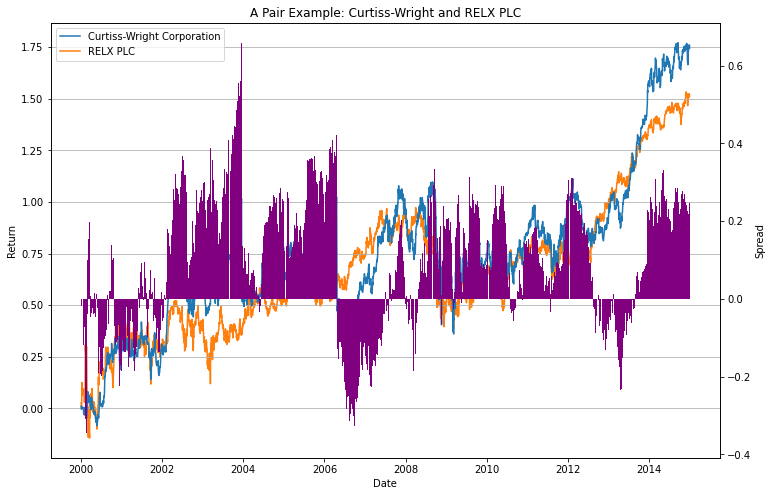

In [350]:
a = price[list(eligible_pair[7])]['2000':'2014']
a['CW'] = a['CW'].apply(my_replace).ffill()
a = a.pct_change().cumsum()
a['spread'] = a['CW'] - a['RUK']
fig, ax = plt.subplots(1,1, figsize = (12,8))
ax2 = ax.twinx()
fig1 = ax2.bar(x = a.index, height = a['spread'], \
        width = 3, color = '#800080',zorder = 3, label = 'spread')
fig2 = ax.plot(a[['CW']],zorder = 2, label = 'Curtiss-Wright Corporation')
fig3 = ax.plot(a[['RUK']],zorder = 1, label = 'RELX PLC')
ax.grid(axis='y')
ax.legend()
ax.set_title('A Pair Example: Curtiss-Wright and RELX PLC')
ax.set_ylabel('Return')
ax2.set_ylabel('Spread')
ax.set_xlabel('Date')

Plot 3: cluster result

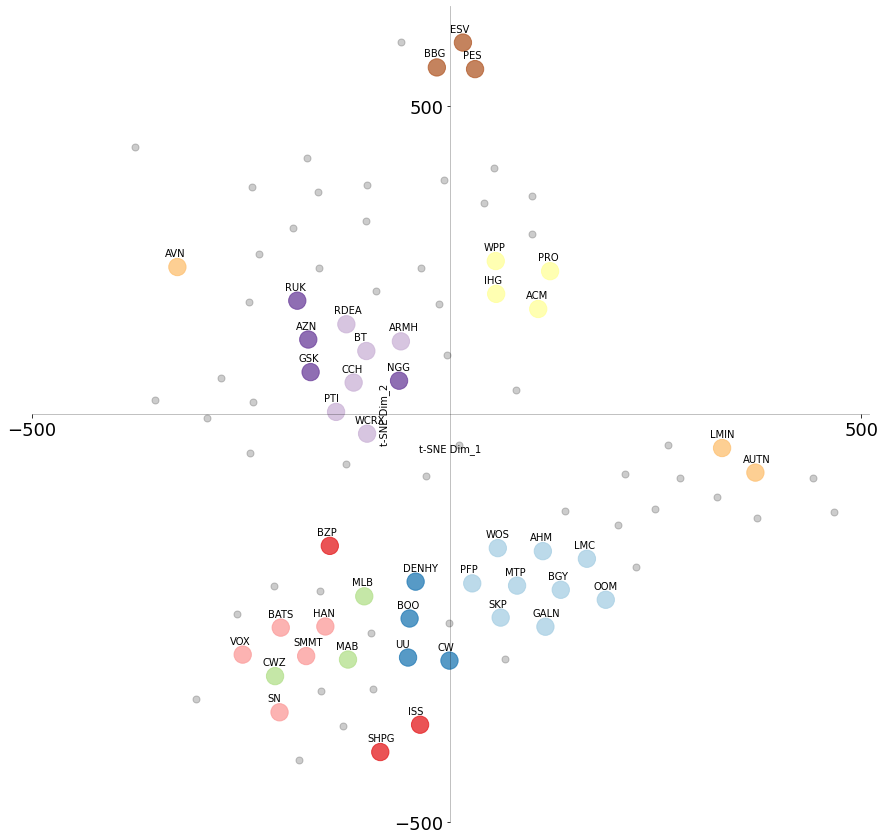

In [ ]:
plot_TSNE(X,clf, clustered_series_all)

Plot 4: boxplot of return